# Data Preprocessing

## 1. Introduction

In this notebook, we will preprocess the data to make it ready for the model. We will focus on data cleaning, integration, and aggregation. We will discuss methodologies investigated and chosen for handling of missing values, feature engineering, and feature selection.

## 2. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

# Load the environment variables
load_dotenv("../config/.env")

scripts_path = os.getenv("SCRIPTS_PATH")

# Add the path to the scripts folder and import the functions
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

In [2]:
# from raw_data import get_raw_dataframes function
from raw_data import get_raw_dataframes

## 3. Load Data

In [3]:
# Load data
city_data, country_data, weather_data, migraine_data = get_raw_dataframes()

# Check the shape of the dataframes
city_data.shape, country_data.shape, weather_data.shape, migraine_data.shape

((1245, 8), (214, 11), (27635763, 14), (42120, 10))

## 4. Data Cleaning

### 4.1 Drop Unnecessary Columns/Rows

#### 4.1.1 DataFrame: `city_data`

In [4]:
# View the `city_data` dataframe
city_data

,station_id,city_name,country,state,iso2,iso3,latitude,longitude
0,41515,Asadabad,Afghanistan,Kunar,AF,AFG,34.866000,71.150005
1,38954,Fayzabad,Afghanistan,Badakhshan,AF,AFG,37.129761,70.579247
2,41560,Jalalabad,Afghanistan,Nangarhar,AF,AFG,34.441527,70.436103
3,38947,Kunduz,Afghanistan,Kunduz,AF,AFG,36.727951,68.872530
4,38987,Qala i Naw,Afghanistan,Badghis,AF,AFG,34.983000,63.133300
...,...,...,...,...,...,...,...,...
1240,67475,Kasama,Zambia,Northern,ZM,ZMB,-10.199598,31.179947
1241,68030,Livingstone,Zambia,Southern,ZM,ZMB,-17.860009,25.860013
1242,67633,Mongu,Zambia,Western,ZM,ZMB,-15.279598,23.120025
1243,67775,Harare,Zimbabwe,Harare,ZW,ZWE,-17.817790,31.044709


Keeping all columns for now.

#### 4.1.2 DataFrame: `country_data`

In [5]:
# View the `country_data` dataframe
country_data

,country,native_name,iso2,iso3,population,area,capital,capital_lat,capital_lng,region,continent
0,Afghanistan,افغانستان,AF,AFG,26023100.0,652230.0,Kabul,34.526011,69.177684,Southern and Central Asia,Asia
1,Albania,Shqipëria,AL,ALB,2895947.0,28748.0,Tirana,41.326873,19.818791,Southern Europe,Europe
2,Algeria,الجزائر,DZ,DZA,38700000.0,2381741.0,Algiers,36.775361,3.060188,Northern Africa,Africa
3,American Samoa,American Samoa,AS,ASM,55519.0,199.0,Pago Pago,-14.275479,-170.704830,Polynesia,Oceania
4,Angola,Angola,AO,AGO,24383301.0,1246700.0,Luanda,-8.827270,13.243951,Central Africa,Africa
...,...,...,...,...,...,...,...,...,...,...,...
209,Wallis and Futuna,Wallis et Futuna,WF,WLF,13135.0,142.0,Mata-Utu,-13.282042,-176.174022,Polynesia,Oceania
210,Western Sahara,الصحراء الغربية,EH,ESH,586000.0,266000.0,El Aaiún,27.154512,-13.195392,Northern Africa,Africa
211,Yemen,اليَمَن,YE,YEM,25956000.0,527968.0,Sana'a,15.353857,44.205884,Middle East,Asia
212,Zambia,Zambia,ZM,ZMB,15023315.0,752612.0,Lusaka,-15.416449,28.282154,Eastern Africa,Europe


*Keeping* the following columns:
- 'country'
- 'iso2'
- 'iso3'

*Removing* the following columns:
- 'native_name'
- 'population'
- 'area'
- 'capital'
- 'capital_lat'
- 'capital_lng'
- 'region'
- 'continent'

In [6]:
# Drop columns that are not needed for the analysis
country_data.drop(columns=['native_name', 'population', 'area', 'capital', 'capital_lat', 'capital_lng', 'region', 'continent'], inplace=True)

# Check the shape of the dataframe
country_data.shape

(214, 3)

#### 4.1.3 DataFrame: `weather_data`

In [7]:
# View the `weather_data` dataframe
weather_data

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min
0,41515,Asadabad,1957-07-01,Summer,27.0,21.1,35.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,41515,Asadabad,1957-07-02,Summer,22.8,18.9,32.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,41515,Asadabad,1957-07-03,Summer,24.3,16.7,35.6,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,41515,Asadabad,1957-07-04,Summer,26.6,16.1,37.8,4.1,NaN,NaN,NaN,NaN,NaN,NaN
4,41515,Asadabad,1957-07-05,Summer,30.8,20.0,41.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24216,67975,Masvingo,2023-09-01,Spring,19.5,9.6,28.4,NaN,NaN,180.0,4.6,NaN,NaN,NaN
24217,67975,Masvingo,2023-09-02,Spring,21.3,10.5,31.4,NaN,NaN,146.0,6.3,NaN,NaN,NaN
24218,67975,Masvingo,2023-09-03,Spring,22.1,13.0,31.5,NaN,NaN,147.0,8.2,NaN,NaN,NaN
24219,67975,Masvingo,2023-09-04,Spring,21.5,13.1,29.7,NaN,NaN,155.0,10.2,NaN,NaN,NaN


*Keeping* the following columns:
- 'station_id'
- 'city_name'
- 'date'
- '*_temp_c' (avg, min, max)
- 'precipitation_mm'
- 'snow_depth_mm'
- 'avg_wind_dir_deg'
- 'avg_wind_speed_kmh'
- 'peak_wind_gust_kmh'
- 'avg_sea_level_pres_hpa'
- 'sunshine_total_min'

*Removing* the following columns:
- 'season'

In [8]:
# Drop columns that are not needed for the analysis
weather_data.drop(columns=['season'], inplace=True)

# Check the shape of the dataframe
weather_data.shape

(27635763, 13)

#### 4.1.4 DataFrame: `migraine_data`

In [9]:
# View the migraine data
migraine_data

,measure,location,sex,age,cause,metric,year,val,upper,lower
0,YLDs (Years Lived with Disability),United States of America,Both,All ages,Migraine,Number,1990,1.671805e+06,3.778398e+06,241755.675720
1,YLDs (Years Lived with Disability),United States of America,Both,All ages,Migraine,Percent,1990,4.717688e-02,1.006749e-01,0.007690
2,YLDs (Years Lived with Disability),United States of America,Both,All ages,Migraine,Rate,1990,6.592145e+02,1.489872e+03,95.327429
3,YLDs (Years Lived with Disability),United States of America,Both,All ages,Migraine,Number,1991,1.685792e+06,3.829800e+06,246742.189926
4,YLDs (Years Lived with Disability),United States of America,Both,All ages,Migraine,Percent,1991,4.728241e-02,1.003127e-01,0.007767
...,...,...,...,...,...,...,...,...,...,...
42115,Incidence,Texas,Both,All ages,Migraine,Percent,2018,2.316704e-03,2.633470e-03,0.002018
42116,Incidence,Texas,Both,All ages,Migraine,Rate,2018,1.238702e+03,1.375767e+03,1093.786554
42117,Incidence,Texas,Both,All ages,Migraine,Number,2019,3.513345e+05,3.901596e+05,310282.248976
42118,Incidence,Texas,Both,All ages,Migraine,Percent,2019,2.221614e-03,2.516136e-03,0.001929


*Keeping* all columns:
- 'measure'
- 'location'
- 'sex'
- 'age'
- 'cause'
- 'metric'
- 'year'
- 'val'
- 'upper'
- 'lower'

In [10]:
# Check the shape of the dataframe
migraine_data.shape

(42120, 10)

In [11]:
# Check the unique values of the measure_name column
migraine_data['measure'].unique()

array(['YLDs (Years Lived with Disability)', 'Prevalence', 'Incidence'],
      dtype=object)

In [12]:
# Check the unique values of the metric_name column
migraine_data['metric'].unique()

array(['Number', 'Percent', 'Rate'], dtype=object)

For this analysis, we will only be looking at the prevalence (total # of cases in the population) of headache disorders (i.e., migraine, tension-type headache), so we will remove all other rows. In addition, we will remove all percent and rate values, as we are only interested in the total number of cases.

In [13]:
# Filter the data to only include the prevalence and number of headache and migraine cases

# Identify indices to drop for both 'measure' and 'metric'
measure_indices_to_drop = migraine_data[migraine_data['measure'].isin(['YLDs (Years Lived with Disability)', 'Incidence'])].index
metric_indices_to_drop = migraine_data[migraine_data['metric'].isin(['Percent', 'Rate'])].index

# Combine the indices
all_indices_to_drop = measure_indices_to_drop.union(metric_indices_to_drop)

# Drop rows
filtered_migraine_data = migraine_data.drop(all_indices_to_drop)

# Format values in the val, upper, and lower columns to two decimal places
pd.set_option('display.float_format', lambda x:'%.2f' % x)

filtered_migraine_data

,measure,location,sex,age,cause,metric,year,val,upper,lower
14040,Prevalence,United States of America,Both,All ages,Tension-type headache,Number,1990,94137563.02,104944453.93,83914199.49
14043,Prevalence,United States of America,Both,All ages,Tension-type headache,Number,1991,95122542.49,105985784.17,84736206.21
14046,Prevalence,United States of America,Both,All ages,Tension-type headache,Number,1992,96064539.25,107064574.03,85565071.28
14049,Prevalence,United States of America,Both,All ages,Tension-type headache,Number,1993,97013060.67,108116414.83,86411956.23
14052,Prevalence,United States of America,Both,All ages,Tension-type headache,Number,1994,97986471.88,109149023.79,87283374.60
...,...,...,...,...,...,...,...,...,...,...
28065,Prevalence,Washington,Both,All ages,Headache disorders,Number,2015,3015306.92,3214381.32,2808762.95
28068,Prevalence,Washington,Both,All ages,Headache disorders,Number,2016,3041906.05,3242427.97,2828632.30
28071,Prevalence,Washington,Both,All ages,Headache disorders,Number,2017,3068098.60,3268882.95,2854289.62
28074,Prevalence,Washington,Both,All ages,Headache disorders,Number,2018,3093045.11,3300792.17,2874046.06


In [14]:
# Rename `location_name` in migraine_data to `state`
filtered_migraine_data.rename(columns={'location': 'state'}, inplace=True)

# Filter 'United States of America' out of the `state` column
filtered_migraine_data = filtered_migraine_data[filtered_migraine_data['state'] != 'United States of America']

filtered_migraine_data

,measure,state,sex,age,cause,metric,year,val,upper,lower
14220,Prevalence,Georgia,Both,All ages,Headache disorders,Number,1990,2875413.67,3078619.16,2665563.56
14223,Prevalence,Georgia,Both,All ages,Headache disorders,Number,1991,2934665.40,3144336.75,2724736.09
14226,Prevalence,Georgia,Both,All ages,Headache disorders,Number,1992,2994816.92,3204924.80,2780280.62
14229,Prevalence,Georgia,Both,All ages,Headache disorders,Number,1993,3056114.30,3273188.90,2835990.89
14232,Prevalence,Georgia,Both,All ages,Headache disorders,Number,1994,3119125.40,3335414.03,2894770.35
...,...,...,...,...,...,...,...,...,...,...
28065,Prevalence,Washington,Both,All ages,Headache disorders,Number,2015,3015306.92,3214381.32,2808762.95
28068,Prevalence,Washington,Both,All ages,Headache disorders,Number,2016,3041906.05,3242427.97,2828632.30
28071,Prevalence,Washington,Both,All ages,Headache disorders,Number,2017,3068098.60,3268882.95,2854289.62
28074,Prevalence,Washington,Both,All ages,Headache disorders,Number,2018,3093045.11,3300792.17,2874046.06


### 4.2 Review and Plan for Missing Values

#### 4.2.1 DataFrame: `city_data`

In [15]:
# Check for missing values
print("\nCity:\n")
print(city_data.isnull().sum())


City:

station_id     0
city_name      1
country        0
state         28
iso2           6
iso3           0
latitude       0
longitude      0
dtype: int64


Plan: Merge with `country_data` then merge with `weather_data` to fill in missing values.

#### 4.2.2 DataFrame: `country_data`

In [16]:
# Check for missing values
print("\nCountry:\n")
print(country_data.isnull().sum())


Country:

country    0
iso2       1
iso3       0
dtype: int64


Plan: Merge with `city_data` then merge with `weather_data` to fill in missing values.

#### 4.2.3 DataFrame: `weather_data`

In [17]:
# Check for missing values
print("\nWeather:\n")
print(weather_data.isnull().sum())


Weather:

station_id                       0
city_name                    13993
date                             0
avg_temp_c                 6230907
min_temp_c                 5718229
max_temp_c                 5539346
precipitation_mm           6642500
snow_depth_mm             24208615
avg_wind_dir_deg          24183195
avg_wind_speed_kmh        22350295
peak_wind_gust_kmh        26514277
avg_sea_level_pres_hpa    23618606
sunshine_total_min        26614302
dtype: int64


Plan: Merge with combined `city_data` and `country_data` then filter by country and year to fill in missing values.

#### 4.2.4 DataFrame: `filtered_migraine_data`

In [18]:
# Check for missing values
print("\nFiltered Migraine:\n")
print(filtered_migraine_data.isnull().sum())


Filtered Migraine:

measure    0
state      0
sex        0
age        0
cause      0
metric     0
year       0
val        0
upper      0
lower      0
dtype: int64


No missing values.

Plan: Merge with combined and filtered weather data.

## 5. Data Integration

### 5.1 Overview

Briefly introduce the goal of data integration in the context of this project. Provide a high-level view of the datasets that will be integrated.

### 5.2 Data Sources

#### 5.2.1 Weather Data

The weather data provides context regarding sea level pressure, sunshine, temperature, and precipitation for each city. This data is relevant because it provides information about the weather conditions that may be associated with migraine prevalence. The country data will be combined with the city data to provide additional information about each city, such as the country, region, and continent. The combined city and country data will then be combined with the weather data to provide additional information.

The daily weather data source file is quite large and is provided in a .parquet format for low memory consumption and data type preservation. 

##### 5.2.1.1 Cities DataFrame

| Attribute            | Description                                        |
|----------------------|----------------------------------------------------|
| **Data Source Name** | cities.csv                                         |
| **Data Source Format** | CSV (comma-separated values)                       |
| **Data Source Desc** | Individual cities and weather stations around the world |
| **Data Source Size** | 84.1 KB                                             |
|                      | 1245 rows                                           |
|                      | 8 columns                                           |
| **Data Source Limits** | None                                              |
| **Data Source Usability** | 10.00                                          |

**Data Source Columns**

| Column Name  | Description                               |
|--------------|-------------------------------------------|
| `station_id` | Unique ID for the weather station.        |
| `city_name`  | Name of the city.                         |
| `country`    | The country where the city is located.    |
| `state`      | The state or province within the country. |
| `iso2`       | The two-letter country code.              |
| `iso3`       | The three-letter country code.            |
| `latitude`   | Latitude coordinate of the city.          |
| `longitude`  | Longitude coordinate of the city.         |


##### 5.2.1.2 Countries DataFrame

| Attribute            | Description                                        |
|----------------------|----------------------------------------------------|
| **Data Source Name** | countries.csv                                         |
| **Data Source Format** | CSV (comma-separated values)                       |
| **Data Source Desc** | Individual country geographic and demographic characteristics |
| **Data Source Size** | 20.6 KB                        |
|                      | 214 rows                                    |
|                      | 11 columns                                       |
| **Data Source Limits** | None                                              |
| **Data Source Usability** | 10.00                                           |

**Data Source Columns**

| Column Name  | Description                                               |
|--------------|-----------------------------------------------------------|
| `iso3`       | The three-letter code representing the country.           |
| `country`    | The English name of the country.                          |
| `native_name`| The native name of the country.                           |
| `iso2`       | The two-letter code representing the country.             |
| `population` | The population of the country.                            |
| `area`       | The total land area of the country in square kilometers.  |
| `capital`    | The name of the capital city.                             |
| `capital_lat`| The latitude coordinate of the capital city.              |
| `capital_lng`| The longitude coordinate of the capital city.             |
| `region`     | The specific region within the continent where the country is located. |
| `continent`  | The continent to which the country belongs.               |

##### 5.2.1.3 Daily Weather DataFrame

| Attribute            | Description                                        |
|----------------------|----------------------------------------------------|
| **Data Source Name** | daily_weather.parquet                              |
| **Data Source Format** | .parquet (compressed, maintains original data types, efficient)|
| **Data Source Desc** | Daily weather data                            |
| **Data Source Size** | 233 MB                                    |
|                      | 27635763 rows                             |
|                      | 14 columns                                 |
| **Data Source Limits** | None                                              |
| **Data Source Usability** | 10.00                                           |

**Data Source Columns**

| Column Name            | Description                                       |
|------------------------|---------------------------------------------------|
| `station_id`           | Unique ID for the weather station.                |
| `city_name`            | Name of the city where the station is located.    |
| `date`                 | Date of the weather record.                       |
| `season`               | Season corresponding to the date (e.g., summer, winter).|
| `avg_temp_c`           | Average temperature in Celsius.                   |
| `min_temp_c`           | Minimum temperature in Celsius.                   |
| `max_temp_c`           | Maximum temperature in Celsius.                   |
| `precipitation_mm`     | Precipitation in millimeters.                     |
| `snow_depth_mm`        | Snow depth in millimeters.                        |
| `avg_wind_dir_deg`     | Average wind direction in degrees.                |
| `avg_wind_speed_kmh`   | Average wind speed in kilometers per hour.        |
| `peak_wind_gust_kmh`   | Peak wind gust in kilometers per hour.            |
| `avg_sea_level_pres_hpa`| Average sea-level pressure in hectopascals.      |
| `sunshine_total_min`   | Total sunshine duration in minutes.               |

#### 5.2.2 Migraine Data

The migraine data provides information about the prevalence of migraine in different countries and, more specifically, within the United States. This data is relevant because it provides information about the prevalence of migraine by gender, age, year, and location. This data will be combined with the weather data to determine if there is a relationship between weather and migraine prevalence.

| Attribute            | Description                                        |
|----------------------|----------------------------------------------------|
| **Data Source Name** | IHME-GBD_2019_DATA-361f72c5-1.csv                  |
| **Data Source Format** | CSV (comma-separated values)                     |
| **Data Source Desc** | All GBD causes, risks, impairments, etiologies, and injuries by nature |
| **Data Source Size** | 5.2 MB                                              |
|                      | 42120 rows                                          |
|                      | 10 columns                                          |
| **Data Source Limits** | None                                              |
| **Data Source Usability** | 10.00                                          |

**Data Source Columns**

| Column Name    | Description                                          |
|----------------|------------------------------------------------------|
| `measure` | The name of measure.                                      |
| `location`| The name of each location.                                |
| `sex`     | The name of each sex choice.                              |
| `age`     | The name of each age group.                               |
| `cause`   | The name of each cause.                                   |
| `metric`  | The name of each metric/unit.                             |
| `year`    | The annual results for all measures.                      |
| `val`     | The value of each metric/unit.                            |
| `upper`   | The 95% Uncertainty Interval - Upper Bound value.         |
| `lower`   | The 95% Uncertainty Interval - Lower Bound value.         |

### 5.3 Preliminary Steps

**Overview**

In this section, the focus is on preparing the dataset for further analysis and exploration. The steps include merging multiple data sources, filtering the data based on specific criteria, cleaning the data by dropping unnecessary columns and rows, and conducting a preliminary analysis through correlation metrics. Each of these steps is essential for ensuring the data's integrity, usability, and relevance to the study objectives.

**5.3.1 Data Merging**

The first step involves merging the city and country datasets using a common identifier. This integration provides a comprehensive view that combines geographical and political attributes. Following that, the weather dataset is integrated with the already combined city-country data. The resulting dataset offers a rich context, incorporating both geographical information and meteorological variables.

**5.3.2 Data Filtering**

The dataset is filtered to only include records pertaining to US cities, thereby narrowing the scope for more targeted analysis. Further filtering is done to include only specific years, enhancing the dataset's relevance to the study period.

**5.3.3 Data Cleaning**

Columns that do not contribute to the analysis or contain redundant information are dropped to simplify the dataset. Rows with missing or irrelevant data are removed to improve the dataset's quality and consistency. Duplicate rows, if any, are identified and removed to ensure each record in the dataset is unique.

**5.3.4 Preliminary Analysis**

A correlation analysis is conducted on specific weather attributes like temperature, precipitation, and wind speed to identify any significant relationships among them.

---

Throughout these steps, the data are continuously inspected to understand their structures, types, and quality. Various data profiling techniques are employed, such as examining data distributions, checking for missing values, and assessing data types, to ensure that the dataset meets the quality and integrity requirements for downstream analysis.

#### 5.3.1 Data Merging

##### 5.3.1.1 Merge `city_data` and `country_data`

Join the countries and cities tables on the `country`, `iso2`, and `iso3` columns to give more context to the weather data.

In [19]:
# Code for joining countries and cities
city_country = city_data.merge(country_data, 
                               how='left', 
                               left_on=['country', 'iso2', 'iso3'], 
                               right_on=['country', 'iso2', 'iso3']
                               )

# Review the shape of the new dataframe
city_country

,station_id,city_name,country,state,iso2,iso3,latitude,longitude
0,41515,Asadabad,Afghanistan,Kunar,AF,AFG,34.87,71.15
1,38954,Fayzabad,Afghanistan,Badakhshan,AF,AFG,37.13,70.58
2,41560,Jalalabad,Afghanistan,Nangarhar,AF,AFG,34.44,70.44
3,38947,Kunduz,Afghanistan,Kunduz,AF,AFG,36.73,68.87
4,38987,Qala i Naw,Afghanistan,Badghis,AF,AFG,34.98,63.13
...,...,...,...,...,...,...,...,...
1240,67475,Kasama,Zambia,Northern,ZM,ZMB,-10.20,31.18
1241,68030,Livingstone,Zambia,Southern,ZM,ZMB,-17.86,25.86
1242,67633,Mongu,Zambia,Western,ZM,ZMB,-15.28,23.12
1243,67775,Harare,Zimbabwe,Harare,ZW,ZWE,-17.82,31.04


##### 5.3.1.2 Merge `weather_data` and `city_country`

Join the weather data with the combined countries and cities tables on the `station_id` and `city_name` columns.

In [20]:
# Review the shape of the weather dataframe
print(f"Weather Data: {weather_data.shape}")

# Review the shape of the city-country dataframe
print(f"City-Country Data: {city_country.shape}")

Weather Data: (27635763, 13)
City-Country Data: (1245, 8)


In [21]:
# Combine city/country with daily weather data
combined_weather = weather_data.merge(city_country, 
                                      how='left', 
                                      left_on=['station_id', 'city_name'], 
                                      right_on=['station_id', 'city_name']
)

# Review the shape of the new dataframe
print(f"Combined Weather Data: {combined_weather.shape}")

Combined Weather Data: (27678323, 19)


#### 5.3.2 Data Filtering

##### 5.3.2.1 Filter `combined_weather` by US Cities

In [22]:
# Filter the combined weather data to only include the US
usa_weather = combined_weather[combined_weather['iso3'] == 'USA']

# Review the shape of the new dataframe
usa_weather.shape

(1481287, 19)

In [23]:
# View 10 rows of the new dataframe
usa_weather

,station_id,city_name,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,country,state,iso2,iso3,latitude,longitude
25096563,72518,Albany,1938-06-01,NaN,8.30,26.70,0.00,0.00,NaN,NaN,NaN,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82
25096564,72518,Albany,1938-06-02,NaN,9.40,26.10,5.10,0.00,NaN,NaN,NaN,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82
25096565,72518,Albany,1938-06-03,NaN,13.90,23.30,4.10,0.00,NaN,NaN,NaN,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82
25096566,72518,Albany,1938-06-04,NaN,9.40,25.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82
25096567,72518,Albany,1938-06-05,NaN,13.30,22.20,0.00,0.00,NaN,NaN,NaN,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26577845,72405,Washington,2023-09-01,22.20,18.50,25.30,NaN,NaN,74.00,10.10,NaN,1018.80,NaN,United States of America,District of Columbia,US,USA,38.90,-77.01
26577846,72405,Washington,2023-09-02,24.30,20.20,28.60,NaN,NaN,98.00,10.10,NaN,1017.70,NaN,United States of America,District of Columbia,US,USA,38.90,-77.01
26577847,72405,Washington,2023-09-03,25.40,21.50,29.50,NaN,NaN,173.00,11.10,NaN,1015.20,NaN,United States of America,District of Columbia,US,USA,38.90,-77.01
26577848,72405,Washington,2023-09-04,25.80,22.10,30.10,NaN,NaN,183.00,12.00,NaN,1013.60,NaN,United States of America,District of Columbia,US,USA,38.90,-77.01


In [24]:
# Check for missing values
usa_weather.isnull().sum()

station_id                      0
city_name                       0
date                            0
avg_temp_c                 545686
min_temp_c                   2584
max_temp_c                   2526
precipitation_mm            23241
snow_depth_mm              177509
avg_wind_dir_deg          1024517
avg_wind_speed_kmh         532918
peak_wind_gust_kmh        1048359
avg_sea_level_pres_hpa     617464
sunshine_total_min         971919
country                         0
state                           0
iso2                            0
iso3                            0
latitude                        0
longitude                       0
dtype: int64

In [25]:
# Check the unique values of the iso3 column, confirming no other countries are included
usa_weather['iso3'].unique()

array(['USA'], dtype=object)

##### 5.3.2.2 Filter `usa_weather` by Year

Given that the migraine data is annual, we need to add a 'year' column to the weather data and filter it by year.

In [26]:
# confirmed that date column is in datetime format
usa_weather.dtypes

station_id                        object
city_name                         object
date                      datetime64[ns]
avg_temp_c                       float64
min_temp_c                       float64
max_temp_c                       float64
precipitation_mm                 float64
snow_depth_mm                    float64
avg_wind_dir_deg                 float64
avg_wind_speed_kmh               float64
peak_wind_gust_kmh               float64
avg_sea_level_pres_hpa           float64
sunshine_total_min               float64
country                           object
state                             object
iso2                              object
iso3                              object
latitude                         float64
longitude                        float64
dtype: object

In [27]:
usa_weather = usa_weather.copy()

# Add a column for the year using .loc, specifying to add a new column for all rows
usa_weather['year'] = usa_weather['date'].dt.year

# Add a column for the month using .loc, specifying to add a new column for all rows
usa_weather['month'] = usa_weather['date'].dt.month

usa_weather.head()

,station_id,city_name,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,country,state,iso2,iso3,latitude,longitude,year,month
25096563,72518,Albany,1938-06-01,NaN,8.30,26.70,0.00,0.00,NaN,NaN,NaN,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,1938,6
25096564,72518,Albany,1938-06-02,NaN,9.40,26.10,5.10,0.00,NaN,NaN,NaN,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,1938,6
25096565,72518,Albany,1938-06-03,NaN,13.90,23.30,4.10,0.00,NaN,NaN,NaN,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,1938,6
25096566,72518,Albany,1938-06-04,NaN,9.40,25.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,1938,6
25096567,72518,Albany,1938-06-05,NaN,13.30,22.20,0.00,0.00,NaN,NaN,NaN,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,1938,6


In [28]:
usa_weather['year'].unique()

array([1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1915, 1916, 1917, 1918, 1919,
       1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1872,
       1873, 1874, 1875, 1876, 1887, 1888, 1889, 1890, 1891, 1892, 1893,
       1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904,
       1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914])

In [29]:
usa_weather['year'].describe()

count   1481287.00
mean       1979.33
std          27.79
min        1872.00
25%        1959.00
50%        1981.00
75%        2002.00
max        2023.00
Name: year, dtype: float64

Earliest year is 1872, latest year is 2023. We will filter the weather data to only include years 1990-2019 to match the migraine data's date range.

In [30]:
usa_weather.shape

(1481287, 21)

In [31]:
# Filter the data to only include the years 1990-2019
year_filter = (usa_weather['year'] >= 1990) & (usa_weather['year'] <= 2019)
usa_weather = usa_weather[year_filter]

# Review the shape of the new dataframe
usa_weather.shape

(530704, 21)

In [32]:
usa_weather['year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [33]:
usa_weather.isnull().sum()

station_id                     0
city_name                      0
date                           0
avg_temp_c                 42210
min_temp_c                    63
max_temp_c                    52
precipitation_mm              46
snow_depth_mm              93426
avg_wind_dir_deg          374372
avg_wind_speed_kmh         36061
peak_wind_gust_kmh        440062
avg_sea_level_pres_hpa     96993
sunshine_total_min        371650
country                        0
state                          0
iso2                           0
iso3                           0
latitude                       0
longitude                      0
year                           0
month                          0
dtype: int64

#### 5.3.3 Data Cleaning (2nd Round)

##### 5.3.3.1 Drop Unnecessary Columns

After further review of the data, the `country` and `iso2` columns are no longer needed since we have filtered for iso3=USA, so we will drop them.

In [34]:
# List of columns to keep
columns_to_keep = [col for col in usa_weather.columns if col not in ['country', 'iso2']]

# Use .loc to select only the columns to keep
usa_weather = usa_weather.loc[:, columns_to_keep]

In [35]:
# Review the shape of the new dataframe
usa_weather.shape

(530704, 19)

##### 5.3.3.2 Drop Unnecessary Rows

In [36]:
usa_weather.isnull().sum()

station_id                     0
city_name                      0
date                           0
avg_temp_c                 42210
min_temp_c                    63
max_temp_c                    52
precipitation_mm              46
snow_depth_mm              93426
avg_wind_dir_deg          374372
avg_wind_speed_kmh         36061
peak_wind_gust_kmh        440062
avg_sea_level_pres_hpa     96993
sunshine_total_min        371650
state                          0
iso3                           0
latitude                       0
longitude                      0
year                           0
month                          0
dtype: int64

In [37]:
# Drop rows with missing values
usa_weather = usa_weather.dropna(subset=['min_temp_c', 'max_temp_c', 'precipitation_mm'])

# Review the shape of the new dataframe
usa_weather.shape

(530594, 19)

In [38]:
# Check for missing values
usa_weather.isnull().sum()

station_id                     0
city_name                      0
date                           0
avg_temp_c                 42168
min_temp_c                     0
max_temp_c                     0
precipitation_mm               0
snow_depth_mm              93354
avg_wind_dir_deg          374275
avg_wind_speed_kmh         36043
peak_wind_gust_kmh        439952
avg_sea_level_pres_hpa     96906
sunshine_total_min        371555
state                          0
iso3                           0
latitude                       0
longitude                      0
year                           0
month                          0
dtype: int64

##### 5.3.3.3 Drop Duplicate Rows

In [39]:
# Original DataFrame
usa_weather_row_count = len(usa_weather)

# DataFrame after dropping duplicates
usa_weather_deduplicated = usa_weather.drop_duplicates()
deduplicated_row_count = len(usa_weather_deduplicated)

# Calculate the number of rows that would be dropped
rows_to_be_dropped = usa_weather_row_count - deduplicated_row_count

# Print the difference
print(f"Rows to be dropped: {rows_to_be_dropped}")

Rows to be dropped: 0


#### 5.3.4 Preliminary Analysis

##### 5.3.4.1 Correlation Analysis for Weather Features

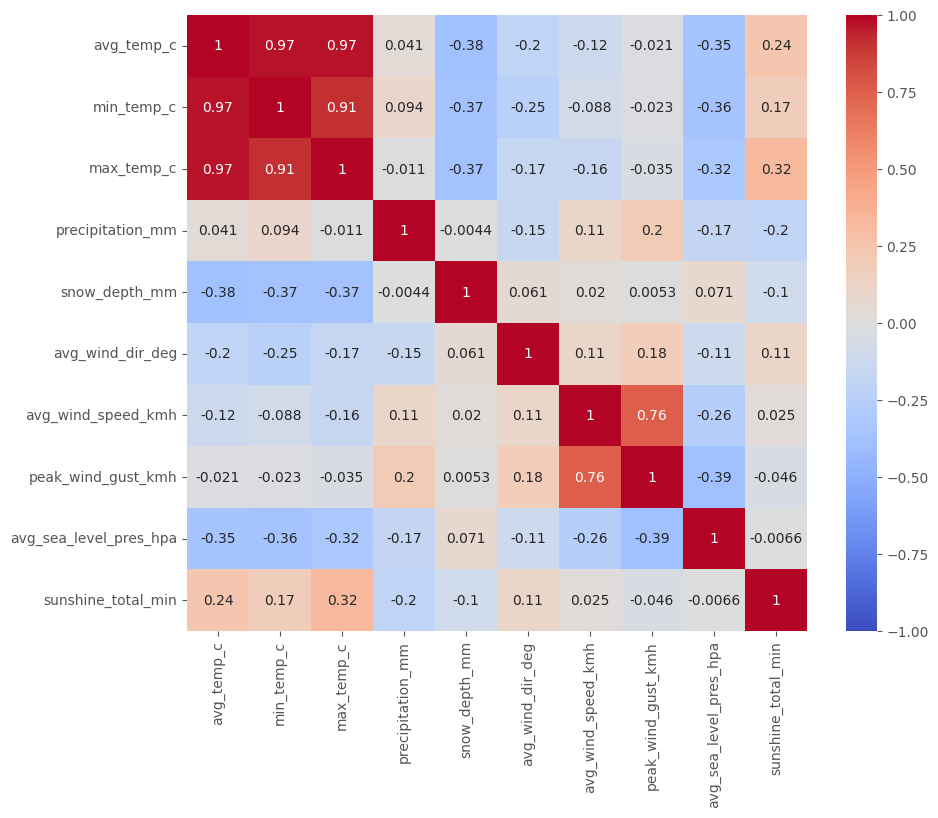

In [40]:
weather_features = ['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg',\
                     'avg_wind_speed_kmh', 'peak_wind_gust_kmh', 'avg_sea_level_pres_hpa', 'sunshine_total_min']
correlation_matrix_usa_weather = usa_weather[weather_features].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_usa_weather, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

The `sunshine_total_min` column has a lot of missing values, has a very weak correlation (-0.0066) with `avg_sea_level_pres_hpa`, and is not a focal point of this analysis, so we will drop that column.

In [41]:
# Columns to keep
columns_to_keep = [col for col in usa_weather.columns if col not in ['sunshine_total_min']]

# Use .loc to select only the columns to keep
usa_weather = usa_weather.loc[:, columns_to_keep]

# Check for missing values
usa_weather.isnull().sum()

station_id                     0
city_name                      0
date                           0
avg_temp_c                 42168
min_temp_c                     0
max_temp_c                     0
precipitation_mm               0
snow_depth_mm              93354
avg_wind_dir_deg          374275
avg_wind_speed_kmh         36043
peak_wind_gust_kmh        439952
avg_sea_level_pres_hpa     96906
state                          0
iso3                           0
latitude                       0
longitude                      0
year                           0
month                          0
dtype: int64

### 5.4 Handling Missing Values

#### 5.4.1 Non-pressure-related Columns

##### 5.4.1.1 Average Temperature Interpolation and Validation

For the `avg_temp_c` missing values, we will calculate the average of the `min_temp_c` and `max_temp_c` columns and use that value to fill in the missing average temperature values. A new, temporary column will be created called `avg_temp_c_interpolated` to hold these values.

In [42]:
# Create a copy of the dataframe
usa_weather = usa_weather.copy()

# Create a column for calculating the `avg_temp_c` using the `min_temp_c` and `max_temp_c` columns
usa_weather['avg_temp_c_interpolated'] = usa_weather['avg_temp_c'].combine_first\
    ((usa_weather['min_temp_c'] + usa_weather['max_temp_c']) / 2)

Utilize the mean absolute error (MAE) to determine the accuracy of the interpolated values.

In [43]:
# Import mean_absolute_error from sklearn.metrics
from sklearn.metrics import mean_absolute_error

# Filter out rows where either of the two columns is NaN
filtered_df = usa_weather.dropna(subset=['avg_temp_c', 'avg_temp_c_interpolated'])

# Calculate mean absolute error
mae = mean_absolute_error(filtered_df['avg_temp_c'], filtered_df['avg_temp_c_interpolated'])

# Print the mean absolute error
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 0.0


As noted above, the MAE is 0.0, so we will use the interpolated values to fill in the missing values for the `avg_temp_c` column. We will then drop the `avg_temp_c_interpolated` column. Please note after further investigation, it was found that the original `avg_temp_c` values are precisely calculated as the average of `min_temp_c` and `max_temp_c` values, so there is no loss of information.

Replace the missing values in the `avg_temp_c` column with the values from the `avg_temp_c_interpolated` column.

In [44]:
# Fill missing values in the 'avg_temp_c' column with the average of the 
# 'min_temp_c' and 'max_temp_c' columns
usa_weather['avg_temp_c'] = usa_weather['avg_temp_c_interpolated']

Drop the `avg_temp_c_interpolated` column and check for any remaining missing values.

In [45]:
# Drop the 'avg_temp_c_interpolated' column
usa_weather.drop(columns=['avg_temp_c_interpolated'], inplace=True)

# Check for missing values
usa_weather.isnull().sum()

station_id                     0
city_name                      0
date                           0
avg_temp_c                     0
min_temp_c                     0
max_temp_c                     0
precipitation_mm               0
snow_depth_mm              93354
avg_wind_dir_deg          374275
avg_wind_speed_kmh         36043
peak_wind_gust_kmh        439952
avg_sea_level_pres_hpa     96906
state                          0
iso3                           0
latitude                       0
longitude                      0
year                           0
month                          0
dtype: int64

In [46]:
# Print the shape of the dataframe
print(f"Original Shape: {usa_weather.shape}")

Original Shape: (530594, 18)


##### 5.4.1.2 Aggregate Weather Data by Year and State

The migraine data is aggregated at an annual level and broken down by state, so we need to aggregate the weather data to match. A mean aggregation will be used for all columns except for the `precipitation_mm` and `snow_depth_mm` columns, which will be aggregated using a sum.

1. **Group by Year, State, and City Name**: Use pandas' `groupby` method to group data by both the `year`, `state`, and `city` columns.
2. **Aggregation Functions**: 
    - For temperatures (`avg_temp_c`, `min_temp_c`, `max_temp_c`), the mean is calculated for each year and state.
    - For wind (`avg_wind_dir_deg`, `avg_wind_speed_kmh`, `peak_wind_gust_kmh`), the mean is calculated for each year and state.
    - For `precipitation_mm` and `snow_depth_mm`, the total sum is calculated for each year and state.
    - For `avg_sea_level_pres_hpa`, the mean is calculated, assuming it's relevant to have an annual mean sea level pressure for each state.
3. **Spatial Data**: For latitude and longitude, the first observed value for each year and state is taken, assuming that these values are consistent within each state and year.

By following this methodology, the daily weather data is transformed into an annual summary by state, making it directly comparable with the annual, state-level migraine data for further analysis.

In [47]:
# Group by 'year' and 'state', then aggregate the numerical columns
annual_usa_weather_by_stateCity = usa_weather.groupby(['year', 'state', 'city_name']).agg({
    'avg_temp_c': 'mean',
    'min_temp_c': 'mean',
    'max_temp_c': 'mean',
    'precipitation_mm': 'sum',
    'snow_depth_mm': 'sum',
    'avg_wind_dir_deg': 'mean',
    'avg_wind_speed_kmh': 'mean',
    'peak_wind_gust_kmh': 'mean',
    'avg_sea_level_pres_hpa': 'mean',
    'latitude': 'first',  # Assuming all latitudes are the same for a given year and state
    'longitude': 'first'  # Assuming all longitudes are the same for a given year and state
}).reset_index()

# Review the shape of the new dataframe
annual_usa_weather_by_stateCity.shape

(1457, 14)

In [48]:
annual_usa_weather_by_stateCity.isnull().sum()

year                         0
state                        0
city_name                    0
avg_temp_c                   0
min_temp_c                   0
max_temp_c                   0
precipitation_mm             0
snow_depth_mm                0
avg_wind_dir_deg           143
avg_wind_speed_kmh          89
peak_wind_gust_kmh        1184
avg_sea_level_pres_hpa     138
latitude                     0
longitude                    0
dtype: int64

##### 5.4.1.3 Drop Wind Gust and Wind Direction Columns

In [49]:
annual_usa_weather_by_stateCity.drop(columns=['peak_wind_gust_kmh', 'avg_wind_dir_deg'], inplace=True)

annual_usa_weather_by_stateCity.shape

(1457, 12)

In [50]:
annual_usa_weather_by_stateCity.isnull().sum()

year                        0
state                       0
city_name                   0
avg_temp_c                  0
min_temp_c                  0
max_temp_c                  0
precipitation_mm            0
snow_depth_mm               0
avg_wind_speed_kmh         89
avg_sea_level_pres_hpa    138
latitude                    0
longitude                   0
dtype: int64

##### 5.4.1.4 Linear Interpolation for Average Wind Speed

In [51]:
# Handle missing values for the `avg_wind_speed_kmh` column utilizing linear interpolation
annual_usa_weather_by_stateCity['avg_wind_speed_kmh'].interpolate(method='linear', inplace=True)

# Check for missing values
annual_usa_weather_by_stateCity.isnull().sum()

year                        0
state                       0
city_name                   0
avg_temp_c                  0
min_temp_c                  0
max_temp_c                  0
precipitation_mm            0
snow_depth_mm               0
avg_wind_speed_kmh          0
avg_sea_level_pres_hpa    138
latitude                    0
longitude                   0
dtype: int64

In [52]:
# Check the shape of the dataframe
annual_usa_weather_by_stateCity.shape

(1457, 12)

#### 5.4.2 Pressure-related Columns

Sea level pressure can vary greatly depending on the location of the city and the main focus of this analysisis is to see if there is any correlation between sudden changes in sea level pressure and migraines.  As a result, we will not fill in missing values for the `avg_sea_level_pres_hpa` column without further research.  We will work through four different scenarios to determine which seems most accurate for this situation.
- Scenario #1: Leave/drop missing values for the `avg_sea_level_pres_hpa` value    
- Scenario #2: Utilize linear interpolation to fill in missing values for the `avg_sea_level_pres_hpa` column
- Scenario #3: Utilize forward fill to fill in missing values for the `avg_sea_level_pres_hpa` column
- Scenario #4: Utilize backward fill to fill in missing values for the `avg_sea_level_pres_hpa` column

##### 5.4.2.1 Leaving/Dropping Missing Values (Scenario #1)

In [53]:
# Descriptive statistics for the `avg_sea_level_pres_hpa` column
annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa'].describe()

count   1319.00
mean    1016.81
std        1.56
min     1009.70
25%     1016.11
50%     1017.02
75%     1017.92
max     1019.83
Name: avg_sea_level_pres_hpa, dtype: float64

##### 5.4.2.2 Linear Interpolation (Scenario #2)

In [54]:
# Handle missing values for `avg_sea_level_pres_hpa` column utilizing linear interpolation
annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa_linear'] = annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa'].interpolate(method='linear')

# Check for missing values
annual_usa_weather_by_stateCity.isnull().sum()

year                               0
state                              0
city_name                          0
avg_temp_c                         0
min_temp_c                         0
max_temp_c                         0
precipitation_mm                   0
snow_depth_mm                      0
avg_wind_speed_kmh                 0
avg_sea_level_pres_hpa           138
latitude                           0
longitude                          0
avg_sea_level_pres_hpa_linear      0
dtype: int64

##### 5.4.2.3 Forward Fill (Scenario #3)

In [55]:
# Handle missing values for `avg_sea_level_pres_hpa` column utilizing forward fill
annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa_ffill'] = annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa'].ffill()

# Check for missing values
annual_usa_weather_by_stateCity.isnull().sum()

year                               0
state                              0
city_name                          0
avg_temp_c                         0
min_temp_c                         0
max_temp_c                         0
precipitation_mm                   0
snow_depth_mm                      0
avg_wind_speed_kmh                 0
avg_sea_level_pres_hpa           138
latitude                           0
longitude                          0
avg_sea_level_pres_hpa_linear      0
avg_sea_level_pres_hpa_ffill       0
dtype: int64

##### 5.4.2.4 Backward Fill (Scenario #4)

In [56]:
# Handle missing values for `avg_sea_level_pres_hpa` column utilizing backward fill
annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa_bfill'] = annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa'].bfill()

# Check for missing values
annual_usa_weather_by_stateCity.isnull().sum()

year                               0
state                              0
city_name                          0
avg_temp_c                         0
min_temp_c                         0
max_temp_c                         0
precipitation_mm                   0
snow_depth_mm                      0
avg_wind_speed_kmh                 0
avg_sea_level_pres_hpa           138
latitude                           0
longitude                          0
avg_sea_level_pres_hpa_linear      0
avg_sea_level_pres_hpa_ffill       0
avg_sea_level_pres_hpa_bfill       0
dtype: int64

In [57]:
annual_usa_weather_by_stateCity.describe()

,year,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_speed_kmh,avg_sea_level_pres_hpa,latitude,longitude,avg_sea_level_pres_hpa_linear,avg_sea_level_pres_hpa_ffill,avg_sea_level_pres_hpa_bfill
count,1457.00,1457.00,1457.00,1457.00,1457.00,1457.00,1457.00,1319.00,1457.00,1457.00,1457.00,1457.00,1457.00
mean,2004.59,13.01,7.28,18.76,939.64,3641.03,12.37,1016.81,39.47,-93.20,1016.74,1016.70,1016.77
std,8.64,4.41,4.52,4.59,412.63,7255.23,3.02,1.56,5.55,18.79,1.59,1.71,1.58
min,1990.00,-14.65,-17.70,-11.60,0.00,0.00,1.75,1009.70,21.31,-157.86,1009.70,1009.70,1009.70
25%,1997.00,10.21,4.27,15.66,679.20,0.00,10.15,1016.11,36.17,-104.82,1016.03,1016.01,1016.07
50%,2005.00,12.49,6.97,18.25,997.70,761.00,12.27,1017.02,39.75,-89.40,1016.98,1017.00,1017.00
75%,2012.00,15.41,9.57,21.34,1210.70,3652.00,14.47,1017.92,42.67,-77.45,1017.87,1017.91,1017.88
max,2019.00,26.02,22.72,31.79,2283.80,74065.00,21.56,1019.83,58.31,-69.78,1019.83,1019.83,1019.83


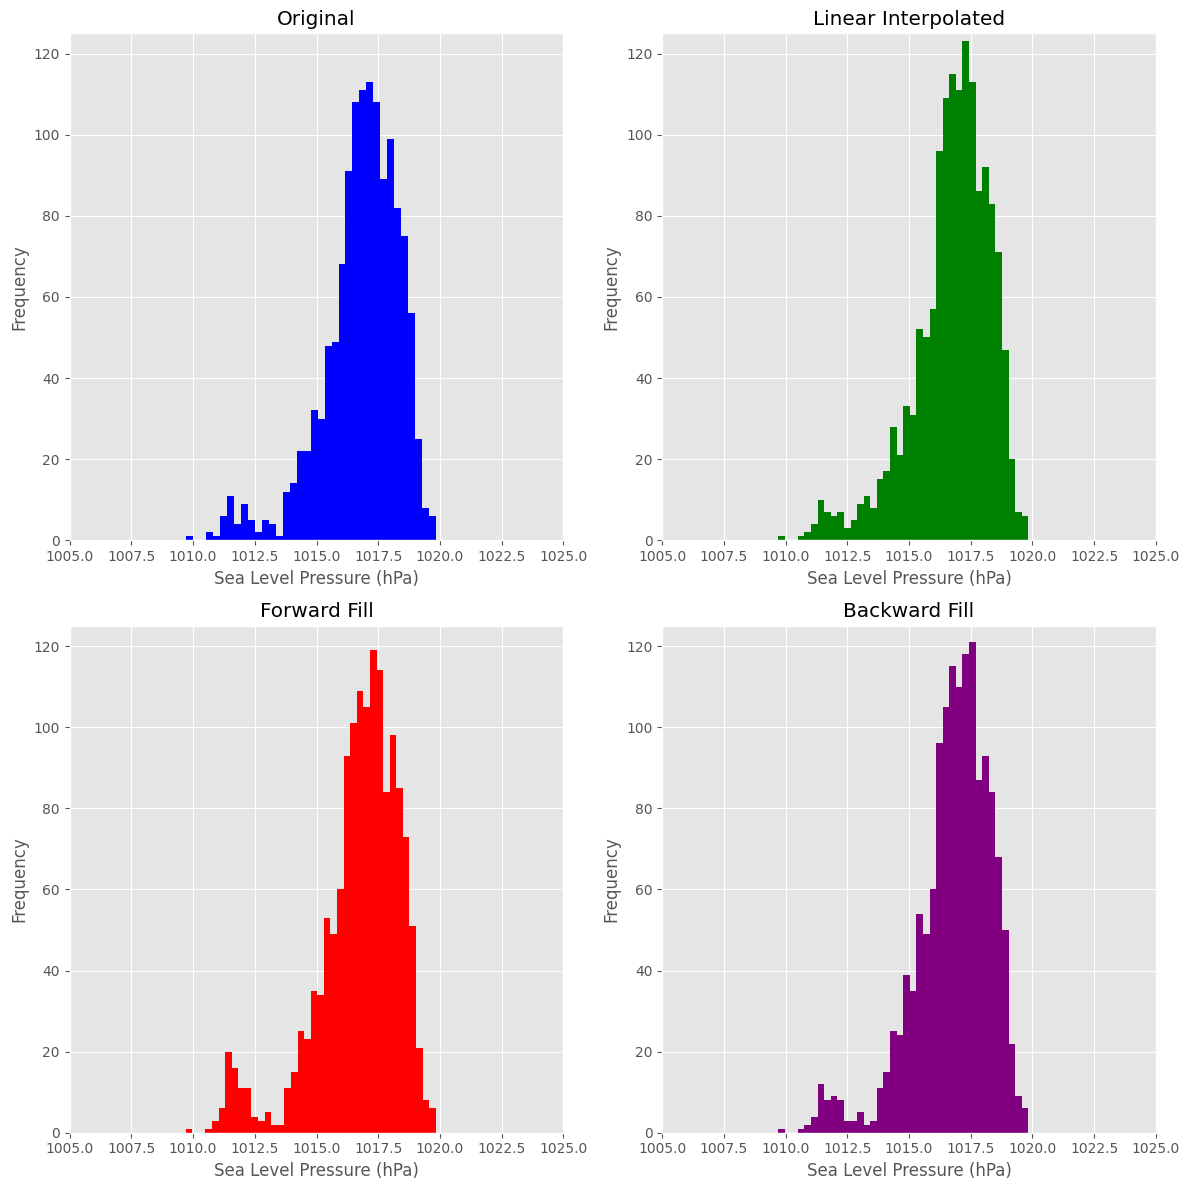

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Define common x and y limits
x_limits = [1005, 1025]  # Replace with the min and max values across all datasets for the x-axis
y_limits = [0, 125]  # Replace with the max frequency across all datasets for the y-axis

# Calculate number of bins for each dataset using the Square Root Rule
num_bins1 = int(np.sqrt(len(annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa'].dropna())))
num_bins2 = int(np.sqrt(len(annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa_linear'].dropna())))
num_bins3 = int(np.sqrt(len(annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa_ffill'].dropna())))
num_bins4 = int(np.sqrt(len(annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa_bfill'].dropna())))

# Plot each histogram on a different subplot
axes[0, 0].hist(annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa'].dropna(), bins=num_bins1, color='blue')
axes[0, 0].set_title('Original')
axes[0, 0].set_xlim(x_limits)
axes[0, 0].set_ylim(y_limits)

axes[0, 1].hist(annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa_linear'].dropna(), bins=num_bins2, color='green')
axes[0, 1].set_title('Linear Interpolated')
axes[0, 1].set_xlim(x_limits)
axes[0, 1].set_ylim(y_limits)

axes[1, 0].hist(annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa_ffill'].dropna(), bins=num_bins3, color='red')
axes[1, 0].set_title('Forward Fill')
axes[1, 0].set_xlim(x_limits)
axes[1, 0].set_ylim(y_limits)

axes[1, 1].hist(annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa_bfill'].dropna(), bins=num_bins4, color='purple')
axes[1, 1].set_title('Backward Fill')
axes[1, 1].set_xlim(x_limits)
axes[1, 1].set_ylim(y_limits)

for ax in axes.flat:
    ax.set(xlabel='Sea Level Pressure (hPa)', ylabel='Frequency')
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

# Display all subplots
plt.tight_layout()
plt.show()


##### 5.4.2.5 Decision on Filling Missing Values

After a thorough review of all four scenarios, we've decided to employ **Scenario #2 (linear interpolation)** for filling the missing values in the `avg_sea_level_pres_hpa` column. The rationale behind this choice is manifold:

- **Representation of Data**: Linear interpolation provides a smoother distribution than the other methods. This approach does not heavily skew the tail ends of the distribution, ensuring a more natural representation.
  
- **Preservation of Original Distribution**: Linear interpolation appears to retain the original data distribution more faithfully when filling in missing values, without introducing any discernible bias towards specific values.

- **Percentage of Missing Values**: With only 138 missing values, which represents 9.47% of the total count of 1457, the sheer accuracy of the method is not as paramount as it would be with a more substantial portion of missing values. Nevertheless, it's essential to utilize a method that delivers reliability, and linear interpolation does just that.

**Analysis of Alternative Methods:**

- The **forward-fill method**, though commendable, might introduce bias as it overlooks subsequent values after a missing point. It stands as our second preference.
  
- The **backward-fill method** is our third choice. While it does consider subsequent data points, its accuracy seems to trail the forward-fill method.
  
- Lastly, simply **leaving or dropping missing values** is the least appealing choice, as it disregards the rest of the dataset's information.


##### 5.4.2.6 Linear Interpolation for Average Sea Level Pressure

In [59]:
# copy the dataframe
annual_usa_weather_by_stateCity = annual_usa_weather_by_stateCity.copy()

# Fill missing values in the `avg_sea_level_pres_hpa` column with the linear values
annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa'] = annual_usa_weather_by_stateCity['avg_sea_level_pres_hpa_linear']

# Drop the `avg_sea_level_pres_hpa_ffill` and `avg_sea_level_pres_hpa_bfill` columns
annual_usa_weather_by_stateCity.drop(columns=['avg_sea_level_pres_hpa_ffill', 'avg_sea_level_pres_hpa_bfill'], inplace=True)

# check for missing values
annual_usa_weather_by_stateCity.isnull().sum()

year                             0
state                            0
city_name                        0
avg_temp_c                       0
min_temp_c                       0
max_temp_c                       0
precipitation_mm                 0
snow_depth_mm                    0
avg_wind_speed_kmh               0
avg_sea_level_pres_hpa           0
latitude                         0
longitude                        0
avg_sea_level_pres_hpa_linear    0
dtype: int64

In [60]:
# Filter out rows where either of the two columns is NaN
filtered_df = annual_usa_weather_by_stateCity.dropna(subset=['avg_sea_level_pres_hpa', 'avg_sea_level_pres_hpa_linear'])

# Calculate mean absolute error
mae = mean_absolute_error(filtered_df['avg_sea_level_pres_hpa'], filtered_df['avg_sea_level_pres_hpa_linear'])

# Print the mean absolute error
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.0


In [61]:
annual_usa_weather_by_stateCity.drop(columns=['avg_sea_level_pres_hpa_linear'], inplace=True)

annual_usa_weather_by_stateCity.isnull().sum()

year                      0
state                     0
city_name                 0
avg_temp_c                0
min_temp_c                0
max_temp_c                0
precipitation_mm          0
snow_depth_mm             0
avg_wind_speed_kmh        0
avg_sea_level_pres_hpa    0
latitude                  0
longitude                 0
dtype: int64

In [62]:
annual_usa_weather_by_stateCity.head()

,year,state,city_name,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_speed_kmh,avg_sea_level_pres_hpa,latitude,longitude
0,1990,Alabama,Montgomery,19.22,12.18,26.75,1355.90,0.00,10.59,1019.33,32.36,-86.28
1,1990,Alaska,Juneau,5.23,1.79,8.55,1458.00,28829.00,13.11,1015.84,58.31,-134.42
2,1990,Arizona,Phoenix,23.77,17.29,30.63,196.90,0.00,9.66,1012.34,33.54,-112.07
3,1990,Arkansas,Little Rock,17.59,12.39,22.78,1617.50,228.00,10.61,1014.14,34.74,-92.33
4,1990,California,Sacramento,15.80,8.79,24.38,349.90,0.00,11.56,1015.94,38.58,-121.47


In [63]:
annual_usa_weather_by_stateCity.shape

(1457, 12)

### 5.6 Join Migraine Data with Weather Data

Now that the weather data has been aggregated to match the migraine data, we can join the two datasets together. These datasets will be joined on the `year` and `state` columns from both the USA weather data and the migraine data.

In [64]:
filtered_migraine_data.head()

,measure,state,sex,age,cause,metric,year,val,upper,lower
14220,Prevalence,Georgia,Both,All ages,Headache disorders,Number,1990,2875413.67,3078619.16,2665563.56
14223,Prevalence,Georgia,Both,All ages,Headache disorders,Number,1991,2934665.40,3144336.75,2724736.09
14226,Prevalence,Georgia,Both,All ages,Headache disorders,Number,1992,2994816.92,3204924.80,2780280.62
14229,Prevalence,Georgia,Both,All ages,Headache disorders,Number,1993,3056114.30,3273188.90,2835990.89
14232,Prevalence,Georgia,Both,All ages,Headache disorders,Number,1994,3119125.40,3335414.03,2894770.35


In [65]:
filtered_migraine_data.shape

(4590, 10)

In [66]:
# Combine USA combined weather with migraine data
usa_weather_migraine = annual_usa_weather_by_stateCity.merge(filtered_migraine_data, 
                                      how='left', 
                                      left_on=['year', 'state'], 
                                      right_on=['year', 'state']
                                      )

# Review the shape of the new dataframe
usa_weather_migraine.shape

(4371, 20)

## 6. Feature Engineering

Discussing any new features that were created and why they were created. Also, discuss any features that were dropped and why they were dropped.

### 6.1 New Features

#### 6.1.1 Converting Celsius to Fahrenheit

##### 6.1.1.1 Convert `avg_temp_c` to `avg_temp_f`

In [67]:
from temp_conversion import celsius_to_fahrenheit

usa_weather_migraine['avg_temp_f'] = usa_weather_migraine['avg_temp_c'].apply(celsius_to_fahrenheit)

##### 6.1.1.2 Convert `min_temp_c` to `min_temp_f`

In [68]:
usa_weather_migraine['min_temp_f'] = usa_weather_migraine['min_temp_c'].apply(celsius_to_fahrenheit)

##### 6.1.1.3 Convert `max_temp_c` to `max_temp_f`

In [69]:
usa_weather_migraine['max_temp_f'] = usa_weather_migraine['max_temp_c'].apply(celsius_to_fahrenheit)

##### 6.1.1.4 Reorder Temperature Columns

In [70]:
# Reorder temperature columns
temp_col = usa_weather_migraine.pop('avg_temp_f')

# Insert columns at new position
usa_weather_migraine.insert(3, 'avg_temp_f', temp_col)

In [71]:
# Reorder temperature columns
temp_col1 = usa_weather_migraine.pop('min_temp_f')

# Insert columns at new position
usa_weather_migraine.insert(4, 'min_temp_f', temp_col1)

In [72]:
# Reorder temperature columns
temp_col2 = usa_weather_migraine.pop('max_temp_f')

# Insert columns at new position
usa_weather_migraine.insert(5, 'max_temp_f', temp_col2)

In [75]:
usa_weather_migraine

,year,state,city_name,avg_temp_f,min_temp_f,max_temp_f,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_speed_kmh,avg_sea_level_pres_hpa,latitude,longitude,measure,sex,age,cause,metric,val,upper,lower,precipitation_in
0,1990,Alabama,Montgomery,66.60,53.92,80.15,19.22,12.18,26.75,1355.90,0.00,10.59,1019.33,32.36,-86.28,Prevalence,Both,All ages,Tension-type headache,Number,1522970.03,1696240.95,1355711.48,53.38
1,1990,Alabama,Montgomery,66.60,53.92,80.15,19.22,12.18,26.75,1355.90,0.00,10.59,1019.33,32.36,-86.28,Prevalence,Both,All ages,Migraine,Number,743282.57,850504.22,647607.37,53.38
2,1990,Alabama,Montgomery,66.60,53.92,80.15,19.22,12.18,26.75,1355.90,0.00,10.59,1019.33,32.36,-86.28,Prevalence,Both,All ages,Headache disorders,Number,1783365.78,1906125.83,1655173.23,53.38
3,1990,Alaska,Juneau,41.41,35.23,47.39,5.23,1.79,8.55,1458.00,28829.00,13.11,1015.84,58.31,-134.42,Prevalence,Both,All ages,Migraine,Number,101075.08,116504.07,87805.46,57.40
4,1990,Alaska,Juneau,41.41,35.23,47.39,5.23,1.79,8.55,1458.00,28829.00,13.11,1015.84,58.31,-134.42,Prevalence,Both,All ages,Tension-type headache,Number,203387.71,229359.69,177743.40,57.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4366,2019,Wisconsin,Madison,46.60,37.35,55.29,8.11,2.97,12.94,1179.50,7920.00,11.25,1017.19,43.07,-89.40,Prevalence,Both,All ages,Migraine,Number,1001012.63,1142874.83,876799.70,46.44
4367,2019,Wisconsin,Madison,46.60,37.35,55.29,8.11,2.97,12.94,1179.50,7920.00,11.25,1017.19,43.07,-89.40,Prevalence,Both,All ages,Headache disorders,Number,2494860.61,2660892.03,2320839.53,46.44
4368,2019,Wyoming,Cheyenne,45.77,33.41,58.55,7.65,0.78,14.75,458.50,4500.00,18.14,1014.44,41.14,-104.82,Prevalence,Both,All ages,Headache disorders,Number,256236.35,273580.06,237941.46,18.05
4369,2019,Wyoming,Cheyenne,45.77,33.41,58.55,7.65,0.78,14.75,458.50,4500.00,18.14,1014.44,41.14,-104.82,Prevalence,Both,All ages,Tension-type headache,Number,217615.63,240231.47,195516.27,18.05


##### 6.1.1.5 Convert `precipitation_mm` to `precipitation_in`

In [74]:
from temp_conversion import mM_to_inches

usa_weather_migraine['precipitation_in'] = usa_weather_migraine['precipitation_mm'].apply(mM_to_inches)


In [78]:
# Reorder temperature columns
temp_col3 = usa_weather_migraine.pop('precipitation_in')

# Insert columns at new position
usa_weather_migraine.insert(9, 'precipitation_in', temp_col3)

In [79]:
usa_weather_migraine.head()

,year,state,city_name,avg_temp_f,min_temp_f,max_temp_f,avg_temp_c,min_temp_c,max_temp_c,precipitation_in,precipitation_mm,snow_depth_mm,avg_wind_speed_kmh,avg_sea_level_pres_hpa,latitude,longitude,measure,sex,age,cause,metric,val,upper,lower
0,1990,Alabama,Montgomery,66.60,53.92,80.15,19.22,12.18,26.75,53.38,1355.90,0.00,10.59,1019.33,32.36,-86.28,Prevalence,Both,All ages,Tension-type headache,Number,1522970.03,1696240.95,1355711.48
1,1990,Alabama,Montgomery,66.60,53.92,80.15,19.22,12.18,26.75,53.38,1355.90,0.00,10.59,1019.33,32.36,-86.28,Prevalence,Both,All ages,Migraine,Number,743282.57,850504.22,647607.37
2,1990,Alabama,Montgomery,66.60,53.92,80.15,19.22,12.18,26.75,53.38,1355.90,0.00,10.59,1019.33,32.36,-86.28,Prevalence,Both,All ages,Headache disorders,Number,1783365.78,1906125.83,1655173.23
3,1990,Alaska,Juneau,41.41,35.23,47.39,5.23,1.79,8.55,57.40,1458.00,28829.00,13.11,1015.84,58.31,-134.42,Prevalence,Both,All ages,Migraine,Number,101075.08,116504.07,87805.46
4,1990,Alaska,Juneau,41.41,35.23,47.39,5.23,1.79,8.55,57.40,1458.00,28829.00,13.11,1015.84,58.31,-134.42,Prevalence,Both,All ages,Tension-type headache,Number,203387.71,229359.69,177743.40


#### 6.1.2 Sea Level Pressure Missing Values

##### 6.1.2.1 Leaving/Dropping Missing Values (Scenario #1)

Utilized existing data without filling in missing values.

##### 6.1.2.2 Linear Interpolation (Scenario #2)

- `avg_sea_level_pres_hpa_linear`: calculated by using linear interpolation to fill in missing values for the average sea level pressure
- `avg_sea_level_pres_hpa_linear_diff`: calculated by subtracting the upper bound of the average sea level pressure with linear interpolation from the lower bound of the average sea level pressure with linear interpolation
- `avg_sea_level_pres_hpa_linear_diff_pct`: calculated by dividing the difference between the upper and lower bounds of the average sea level pressure with linear interpolation by the average sea level pressure with linear interpolation

##### 6.1.2.3 Forward Fill (Scenario #3)

- `avg_sea_level_pres_hpa_ffill`: calculated by using forward fill to fill in missing values for the average sea level pressure
- `avg_sea_level_pres_hpa_ffill_diff`: calculated by subtracting the upper bound of the average sea level pressure with forward fill from the lower bound of the average sea level pressure with forward fill
- `avg_sea_level_pres_hpa_ffill_diff_pct`: calculated by dividing the difference between the upper and lower bounds of the average sea level pressure with forward fill by the average sea level pressure with forward fill

##### 6.1.2.4 Backward Fill (Scenario #4)

- `avg_sea_level_pres_hpa_bfill`: calculated by using backward fill to fill in missing values for the average sea level pressure
- `avg_sea_level_pres_hpa_bfill_diff`: calculated by subtracting the upper bound of the average sea level pressure with backward fill from the lower bound of the average sea level pressure with backward fill
- `avg_sea_level_pres_hpa_bfill_diff_pct`: calculated by dividing the difference between the upper and lower bounds of the average sea level pressure with backward fill by the average sea level pressure with backward fill

### 6.2 Dropped Features

In [ ]:
# usa_weather_migraine.drop(columns=['avg_temp_c', 'min_temp_c', 'max_temp_c'], inplace=True)

# usa_weather_migraine

In [ ]:
# usa_weather_migraine.drop(columns='precipitation_mm', inplace=True)

# usa_weather_migraine

## 7. Summary

Summarize the data preprocessing steps that were taken in this notebook.

## 8. Next Steps

Discuss any next steps that should be taken in the data analysis process/modeling phases.